In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from datetime import date, timedelta
#Statistics
from statsmodels import regression
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import acf, pacf
from scipy.odr import Model, Data, ODR
from sklearn.metrics import r2_score
import math

In [123]:
os.chdir('C:\\blp\\API\\cpp\\bin')

In [2]:
import os
import blpapi
from xbbg import blp

In [288]:
#List of S&P500 Consituents stock
dr=blp.bds(tickers='SPX Index', flds=['INDX_MEMBERS'])
data=dr['member_ticker_and_exchange_code'].reset_index(drop=True).tolist()
sp500equity=[df +' Equity' for df in data]

In [4]:
def CSK(list1,list2):
    #list1 asset return signed, list 2 market return signed and asset 3 market return unsigned
    num=0
    denum=0
    denum1=0
    denum2=0
    m=0
    meanasset=0
    meanmarket=0
    m=len(list1)
    meanasset=list1.mean()
    meanmarket=list2.mean()
    for x,y in list(zip(list1,list2)):
        num+=(x-meanasset)*((y-meanmarket)**2)
        denum1+=(x-meanasset)**2
        denum2+=(y-meanmarket)**2
    num=num/m
    denum1=math.sqrt(denum1/m)
    denum2=denum2/m
    denum=denum1*denum2
    coef=num/denum
    return coef
def CKT(list1,list2):
    #list1 asset return signed, list 2 market return signed and asset 3 market return unsigned
    num=0
    denum=0
    denum1=0
    denum2=0
    m=0
    meanasset=0
    meanmarket=0
    m=len(list1)
    meanasset=list1.mean()
    meanmarket=list2.mean()
    for x,y in list(zip(list1,list2)):
        num+=(x-meanasset)*((y-meanmarket)**3)
        denum1+=(x-meanasset)**2
        denum2+=(y-meanmarket)**2
    num=num/m
    denum1=math.sqrt(denum1/m)
    denum2=(denum2/m)*math.sqrt(denum2/m)
    denum=denum1*denum2
    coef=num/denum
    return coef 

In [5]:
def betacal(list1,list2,list3):
    #list1 asset return signed, list 2 market return signed and asset 3 market return unsigned
    num=0
    denum=0
    for x,y in list(zip(list1,list2)):
        num+=x*y
    for x in list3:
        denum+=x**2
    coef=num/denum
    return coef

In [290]:
#Daily return
dailydf=pd.DataFrame()
for sym in sp500equity:
    ds=blp.bdh(tickers=sym,flds=['open','last_price'],start_date='2020-05-22',end_date='2020-10-6')
    ds.columns=ds.columns.droplevel()
    ds['change']=ds['last_price'].pct_change()
    dailydf=pd.concat([dailydf,ds['change']],axis=1)
dailydf.columns=data

In [293]:
#dailydf.to_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\SPX500DDailyReturn.csv')

### Main Frame [Get beta daily directly from bloomberg]

In [391]:
betaP=pd.DataFrame()
betaN=pd.DataFrame()
betamneg=pd.DataFrame()
betampos=pd.DataFrame()
betanormal=pd.DataFrame()
csk=pd.DataFrame()
ckt=pd.DataFrame()
#asset1 daily

days=pd.bdate_range('2020-05-25','2020-10-06')#business day
for sym in sp500equity:
    dailybeta=pd.DataFrame(columns=['N','P','mneg','mpos','normal','csk','ckt'])
    for day in days:
        asset=blp.bdib(ticker=sym,dt=day,interval=15,ref='US')
        market=blp.bdib(ticker='SPX Index',dt=day,interval=15,ref='US')
        if( not asset.empty and not market.empty): #To account for day light saving not included in business day or any error
            asset.columns=asset.columns.droplevel()
            market.columns=market.columns.droplevel()
            asset['change']=asset['close'].pct_change()
            asset['rpos']=asset['change'].apply(lambda x: x if x>0 else 0)
            asset['rneg']=asset['change'].apply(lambda x: x if x<0 else 0)
            market['ret']=market['close'].pct_change()   
            market['fpos']=market['ret'].apply(lambda x: x if x>0 else 0)
            market['fneg']=market['ret'].apply(lambda x: x if x<0 else 0)
            asset.dropna(inplace=True)
            market.dropna(inplace=True)
            #=================BETA Calculation===============
            N=betacal(asset['rneg'],market['fneg'],market['ret'])
            P=betacal(asset['rpos'],market['fpos'],market['ret'])
            mneg=-betacal(asset['rpos'],market['fneg'],market['ret'])
            mpos=-betacal(asset['rneg'],market['fpos'],market['ret'])
            normal=N+P-mneg-mpos
            csk1=CSK(asset['change'],market['ret'])
            ckt1=CKT(asset['change'],market['ret'])
            dailybeta.loc[len(dailybeta.index)+1]=[N,P,mneg,mpos,normal,csk1,ckt1]
    betaN=pd.concat([betaN,dailybeta['N']],axis=1)
    betaP=pd.concat([betaP,dailybeta['P']],axis=1)
    betamneg=pd.concat([betamneg,dailybeta['mneg']],axis=1)
    betampos=pd.concat([betampos,dailybeta['mpos']],axis=1)
    betanormal=pd.concat([betanormal,dailybeta['normal']],axis=1)
    csk=pd.concat([csk,dailybeta['csk']],axis=1)
    ckt=pd.concat([ckt,dailybeta['ckt']],axis=1)
    
betaP.to_csv('betaP.csv')
betaN.to_csv('betaN.csv')
betamneg.to_csv('betaMNEG.csv')
betampos.to_csv('betampos.csv')
betanormal.to_csv('betanormal.csv')
csk.to_csv('csk.csv')
ckt.to_csv('ckt.csv')


ConnectionError: Cannot connect to Bloomberg

In [663]:
##Extract Csk and Ckt
csk=pd.DataFrame()
ckt=pd.DataFrame()
#asset1 daily

days=pd.bdate_range('2020-05-25','2020-10-06')#business day
for sym in sp500equity:
    dailybeta=pd.DataFrame(columns=['csk','ckt'])
    for day in days:
        asset=blp.bdib(ticker=sym,dt=day,interval=15,ref='US')
        market=blp.bdib(ticker='SPX Index',dt=day,interval=15,ref='US')
        if( not asset.empty and not market.empty): #To account for day light saving not included in business day or any error
            asset.columns=asset.columns.droplevel()
            market.columns=market.columns.droplevel()
            asset['change']=asset['close'].pct_change()
            asset['rpos']=asset['change'].apply(lambda x: x if x>0 else 0)
            asset['rneg']=asset['change'].apply(lambda x: x if x<0 else 0)
            market['ret']=market['close'].pct_change()   
            market['fpos']=market['ret'].apply(lambda x: x if x>0 else 0)
            market['fneg']=market['ret'].apply(lambda x: x if x<0 else 0)
            asset.dropna(inplace=True)
            market.dropna(inplace=True)
            #=================CSK and CKT Calculation===============
            csk1=CSK(asset['change'],market['ret'])
            ckt1=CKT(asset['change'],market['ret'])
            dailybeta.loc[len(dailybeta.index)+1]=[csk1,ckt1]
    csk=pd.concat([csk,dailybeta['csk']],axis=1)
    ckt=pd.concat([ckt,dailybeta['ckt']],axis=1)


ConnectionError: Cannot connect to Bloomberg

### Main Frame [Get beta daily directly from CSV] For AU market.

In [1982]:
equityAS=pd.read_csv("C:\\Users\\raymond.widjaja\\Desktop\\Pairs Trading\\15_min_clean_ASX200.csv")
#equityAS=equityAS.iloc[19:,:]##Start from 26 may 2020

### Preprocess Data Extracted (semi beta only)

### US data

In [695]:
#get data from CSV for US 
#dr=blp.bds(tickers='SPX Index', flds=['INDX_MEMBERS'])
#data=dr['member_ticker_and_exchange_code'].reset_index(drop=True).tolist()
#sp500equity=[df +' Equity' for df in data]
beta1=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betaMNEG.csv')
beta2=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betampos.csv')
beta3=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betaN.csv')
beta4=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betaP.csv')
betaCAPM=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betanormal.csv')
dailydf=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\SPX500DDailyReturn.csv')
#data    : should be used to change the column name 

In [682]:
data=dailydf.columns[1:].tolist()

### AU Data

In [533]:
#get data from CSV for AU
#dr=blp.bds(tickers='AS51 Index', flds=['INDX_MEMBERS'])
#data=dr['member_ticker_and_exchange_code'].reset_index(drop=True).tolist()
#sp500equity=[df +' Equity' for df in data]
beta1=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betaMNEGASX200.csv')
beta2=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betamposASX200.csv')
beta3=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betaNASX200.csv')
beta4=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betaPASX200.csv')
betaCAPM=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\betanormalASX200.csv')
dailydf=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\ASX200DailyReturn.csv')

In [534]:
data=dailydf.columns[1:].tolist() #for AU Market normally

In [696]:
def update(d):
    d.set_index('Unnamed: 0',drop=True,inplace=True) #data 688-5=683
    d.rename_axis(index=None,inplace=True)
    d.columns=data
csvlist=[beta1,beta2,beta3,beta4,betaCAPM,dailydf]
for info in csvlist:
    update(info)

In [697]:
dailyret=dailydf.copy()
dailyret

,A UN,AAL UW,AAP UN,AAPL UW,ABBV UN,ABC UN,ABMD UW,ABT UN,ACN UN,ADBE UW,...,XLNX UW,XOM UN,XRAY UW,XRX UN,XYL UN,YUM UN,ZBH UN,ZBRA UW,ZION UW,ZTS UN
2020-05-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-26 00:00:00,0.013533,0.148454,0.015733,-0.006773,-0.015092,-0.025338,0.014164,-0.021756,0.013887,-0.022400,...,0.020095,0.029372,0.073153,0.026502,0.048698,0.009169,0.027066,0.050998,0.090759,0.002613
2020-05-27 00:00:00,0.000581,0.075404,0.045213,0.004357,-0.008048,0.028090,-0.006313,0.014305,0.017974,-0.003876,...,0.030680,0.007188,0.054269,0.037866,0.055326,0.024872,0.012624,0.010588,0.065290,0.039785
2020-05-28 00:00:00,0.005918,-0.083472,-0.023075,0.000440,0.000556,0.011465,0.046207,0.014764,0.008703,0.012421,...,-0.020760,-0.025952,-0.016740,-0.070757,-0.010166,0.006760,-0.002727,-0.004832,-0.030217,0.018210
2020-05-29 00:00:00,0.016726,-0.043716,0.006357,-0.000980,0.029324,0.009958,0.030088,0.030619,-0.000248,0.017824,...,0.031408,0.009547,-0.010002,-0.055324,-0.026702,-0.012328,-0.012892,0.015150,-0.032775,0.009268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 00:00:00,0.007184,0.003265,0.011799,0.015076,0.008056,0.007903,0.016883,0.034604,0.008524,0.002248,...,0.005886,0.001459,0.022924,0.016793,0.004178,0.006504,0.020540,-0.024950,0.008630,0.017787
2020-10-01 00:00:00,0.002774,0.023596,0.008795,0.008462,-0.005138,-0.016096,-0.059951,-0.001746,-0.003584,0.018514,...,0.016021,-0.034955,-0.005031,-0.005328,-0.018545,0.005696,0.008741,0.023845,-0.003422,-0.008103
2020-10-02 00:00:00,-0.011954,0.033386,0.004198,-0.032280,-0.011705,0.000210,0.005913,-0.019698,-0.012346,-0.041080,...,-0.031347,-0.004528,0.003447,0.020354,0.022650,0.036484,0.002621,0.001277,0.025069,-0.002926
2020-10-05 00:00:00,0.031097,0.009231,0.002315,0.030791,0.021017,0.010589,0.033207,0.019343,0.004901,0.015616,...,0.020957,0.023044,0.026340,0.030971,0.022385,-0.011348,0.028324,0.035547,0.047906,-0.000611


### Check and Delete missing values ifany 

In [701]:
#Check Null value in each column 
dailyret=dailyret.iloc[1:,:] # to remove nan value at first row
missingdata=dailyret.columns[dailyret.isnull().sum()>1].tolist()
missingdata

['AEP UW', 'APA UW', 'VNT UN']

In [699]:
#Reindex beta make sure length is same for each data 
dailydf=dailydf.iloc[1:,:] #for USmarket
bN=beta3.set_index(dailydf.index)
bP=beta4.set_index(dailydf.index)
bmneg=beta1.set_index(dailydf.index)
bmpos=beta2.set_index(dailydf.index)
bnormal=betaCAPM.set_index(dailydf.index)

In [703]:
bmneg.columns[bmneg.isnull().sum()>1].tolist()
missingdata.append('NCLH UN') #discretionary adding mising data based on the line above US/AU depends
missingdata

['AEP UW', 'APA UW', 'VNT UN', 'NCLH UN']

In [705]:
#Delete Column with missing value 
d1=dailyret.drop(missingdata,axis=1)
bN=bN.drop(missingdata,axis=1)
bP=bP.drop(missingdata,axis=1)
bmneg=bmneg.drop(missingdata,axis=1)
bmpos=bmpos.drop(missingdata,axis=1)
bnormal=bnormal.drop(missingdata,axis=1)

In [93]:
#d1=dailyret.drop(missingdata,axis=1)

In [715]:
bmneg.columns[bmneg.isnull().sum()>0]

Index([], dtype='object')

In [710]:
#delete data on 6 oct for all stocks to make sure no more nan value. Do it once only
d1=d1.iloc[:-1]
bN=bN.iloc[:-1]
bP=bP.iloc[:-1]
bmneg=bmneg.iloc[:-1]
bmpos=bmpos.iloc[:-1]
bnormal=bnormal.iloc[:-1]


In [714]:
d1.fillna(0)
d1.columns[d1.isnull().sum()>0]

Index([], dtype='object')

In [161]:
#bmneg.apply(lambda x : x!=0).sum() #test

In [139]:
listbetadata=[bN,bP,bmneg,bmpos,bnormal] #Very discretionary only for AU market.
for bm in listbetadata:
    bm['NWH AT'].iloc[94]=bm['NWH AT'].iloc[93]

### Summary Statistics

In [712]:
## The Time Series Average of cross sectional means, medians and standard deviations averaged across all of the stocks
average=[bnormal,bN,bP,bmpos,bmneg]
summarystat=pd.DataFrame(index=pd.Index(['Mean','Median','St.Dev']),columns=['Beta','BetaN','BetaP','BetaM+','BetaM-'])
def fm_summary(p): #Summary Statistics Function
    std=p.std().mean()
    median=p.median().mean()
    mean=p.mean().mean()
    return (mean,median,std)
count=0
for i in average:
    res=fm_summary(i)
    summarystat[summarystat.columns[count]]=[res[0],res[1],res[2]]
    count+=1

In [713]:
summarystat

,Beta,BetaN,BetaP,BetaM+,BetaM-
Mean,0.896163,0.597136,0.620593,0.175528,0.146039
Median,0.900301,0.545068,0.543203,0.108717,0.083474
St.Dev,0.572710,0.338136,0.383084,0.207628,0.180016


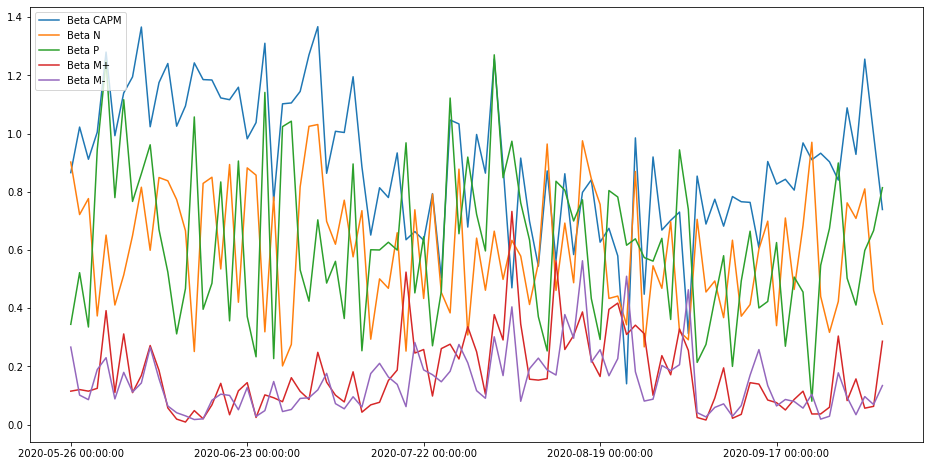

In [716]:
bnormal.mean(axis=1).plot(figsize=(16,10),label='Beta CAPM')
bN.mean(axis=1).plot(figsize=(16,10),label='Beta N')
bP.mean(axis=1).plot(figsize=(16,10),label='Beta P')
bmpos.mean(axis=1).plot(figsize=(16,8),label='Beta M+')
bmneg.mean(axis=1).plot(figsize=(16,8),label='Beta M-')

plt.legend(loc="upper left")

In [717]:
corrDF=pd.DataFrame(columns=['Beta','BetaN','BetaP','BetaM+','BetaM-']) #Average Across Time Function
count=0
for i in average:
    corrDF[corrDF.columns[count]]=i.mean(axis=1).tolist()
    count+=1

In [718]:
corrDF.corr(method="pearson").style.background_gradient(cmap='coolwarm')
#seaborn.heatmap(corrDF.corr(),annot=True)

,Beta,BetaN,BetaP,BetaM+,BetaM-
Beta,1.000000,0.398176,0.216470,-0.369826,-0.467185
BetaN,0.398176,1.000000,-0.515375,-0.190173,0.053913
BetaP,0.216470,-0.515375,1.000000,0.565593,0.237012
BetaM+,-0.369826,-0.190173,0.565593,1.000000,0.586808
BetaM-,-0.467185,0.053913,0.237012,0.586808,1.000000


### Adiional test

In [719]:
##From yfinance for test
sp500=pd.read_csv('C:\\Users\\raymond.widjaja\\Desktop\\SemiBetas Data\\^GSPC.csv')
sp500['change']=sp500['Adj Close'].pct_change()
sp500ret=sp500['change']
sp500ret.dropna(inplace=True)
sp500ret=sp500ret.to_frame()
sp500ret=sp500ret.set_index(d1.index)
sp500ret.columns=['SP500']

### Sensitivity in differnet regime

In [368]:
datadummy=data.copy()

In [369]:
for i in missingdata:
    datadummy.remove(i)

In [365]:
#plt.scatter(d1['AAL UW'],sp500ret)
#plt.axis([-0.2,0.2,-0.04,0.04])
#plt.axvline(x=0)
#plt.axhline(y=0)

In [376]:
df

,A UN,AAL UW,AAP UN,AAPL UW,ABBV UN,ABC UN,ABMD UW,ABT UN,ACN UN,ADBE UW,...,XOM UN,XRAY UW,XRX UN,XYL UN,YUM UN,ZBH UN,ZBRA UW,ZION UW,ZTS UN,A UN
2020-05-26 00:00:00,0.013533,0.148454,0.015733,-0.006773,-0.015092,-0.025338,0.014164,-0.021756,0.013887,-0.022400,...,0.029372,0.073153,0.026502,0.048698,0.009169,0.027066,0.050998,0.090759,0.002613,0.013533
2020-05-27 00:00:00,0.000581,0.075404,0.045213,0.004357,-0.008048,0.028090,-0.006313,0.014305,0.017974,-0.003876,...,0.007188,0.054269,0.037866,0.055326,0.024872,0.012624,0.010588,0.065290,0.039785,0.000581
2020-05-28 00:00:00,0.005918,-0.083472,-0.023075,0.000440,0.000556,0.011465,0.046207,0.014764,0.008703,0.012421,...,-0.025952,-0.016740,-0.070757,-0.010166,0.006760,-0.002727,-0.004832,-0.030217,0.018210,0.005918
2020-05-29 00:00:00,0.016726,-0.043716,0.006357,-0.000980,0.029324,0.009958,0.030088,0.030619,-0.000248,0.017824,...,0.009547,-0.010002,-0.055324,-0.026702,-0.012328,-0.012892,0.015150,-0.032775,0.009268,0.016726
2020-06-01 00:00:00,0.020082,0.058095,0.003374,0.012304,-0.021258,-0.001993,0.010004,-0.020122,0.008729,0.007967,...,0.017814,0.012468,0.070529,-0.005125,0.008804,0.012189,0.013968,0.015651,-0.007533,0.020082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 00:00:00,0.007184,0.003265,0.011799,0.015076,0.008056,0.007903,0.016883,0.034604,0.008524,0.002248,...,0.001459,0.022924,0.016793,0.004178,0.006504,0.020540,-0.024950,0.008630,0.017787,0.007184
2020-10-01 00:00:00,0.002774,0.023596,0.008795,0.008462,-0.005138,-0.016096,-0.059951,-0.001746,-0.003584,0.018514,...,-0.034955,-0.005031,-0.005328,-0.018545,0.005696,0.008741,0.023845,-0.003422,-0.008103,0.002774
2020-10-02 00:00:00,-0.011954,0.033386,0.004198,-0.032280,-0.011705,0.000210,0.005913,-0.019698,-0.012346,-0.041080,...,-0.004528,0.003447,0.020354,0.022650,0.036484,0.002621,0.001277,0.025069,-0.002926,-0.011954
2020-10-05 00:00:00,0.031097,0.009231,0.002315,0.030791,0.021017,0.010589,0.033207,0.019343,0.004901,0.015616,...,0.023044,0.026340,0.030971,0.022385,-0.011348,0.028324,0.035547,0.047906,-0.000611,0.031097


In [370]:
#Sensitivity signed of market and asset return average across 500 stocks
expo1=[]
expo2=[]
expo3=[]
expo4=[]
for sym in datadummy:
    df=pd.concat([dailyret,d1[sym]],axis=1)  # for US change dailyret to sp500ret
    y1=df[(df['SP500']>0)&(df[sym]>0)]
    print(y1)
    y2=df[(df['SP500']<0)&(df[sym]>0)]
    print(y2)
    y3=df[(df['SP500']>0)&(df[sym]<0)]
    y4=df[(df['SP500']<0)&(df[sym]<0)]
    model = sm.OLS(y1['SP500'], sm.add_constant(y1[sym]))
    fit=model.fit()
    expo1.append(fit.params[1])
    
    model = sm.OLS(y2['SP500'], sm.add_constant(y2[sym]))
    fit=model.fit()
    expo2.append(fit.params[1])
    
    model3 = sm.OLS(y3['SP500'], sm.add_constant(y3[sym]))
    fit3=model3.fit()
    expo3.append(fit3.params[1])
    
    model4 = sm.OLS(y4['SP500'], sm.add_constant(y4[sym]))
    fit4=model4.fit()
    expo4.append(fit4.params[1])
   
    
    

KeyError: 'SP500'

In [1905]:
sens=[]
sens.append(np.mean(expo1))
sens.append(np.mean(expo2))
sens.append(np.mean(expo3))
sens.append(np.mean(expo4))

[0.12411610214425804,
 0.023796217219763553,
 0.006574419473572603,
 0.5058996997434418]

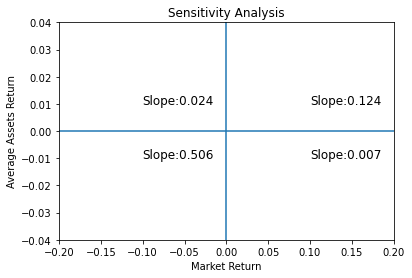

In [1920]:
plt.axis([-0.2,0.2,-0.04,0.04])
plt.axvline(x=0)
plt.axhline(y=0)
plt.text(0.1, 0.01,"Slope:"+str(sens[0].round(3)), fontsize=12)
plt.text(-0.1, 0.01,"Slope:"+str(sens[1].round(3)), fontsize=12)
plt.text(0.1, -0.01,"Slope:"+str(sens[2].round(3)), fontsize=12)
plt.text(-0.1, -0.01,"Slope:"+str(sens[3].round(3)), fontsize=12)
plt.xlabel('Market Return')
plt.ylabel('Average Assets Return')
plt.title('Sensitivity Analysis')
sens

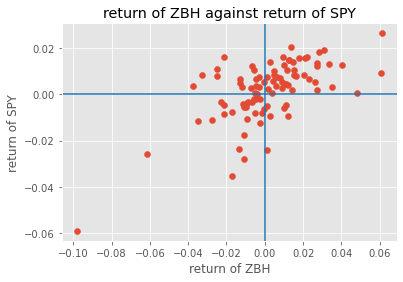

In [395]:
with plt.style.context("ggplot"):
    plt.scatter(dailyret[:-1]['ZBH UN'],sp500ret)
    plt.xlabel("return of ZBH")
    plt.ylabel("return of SPY")
    plt.title("return of ZBH against return of SPY")
    plt.axhline()
    plt.axvline()

### Unconditional Distributions and Autocorrelations of the semi betas

Text(0.5, 1.0, 'Distribution of Semibetas')

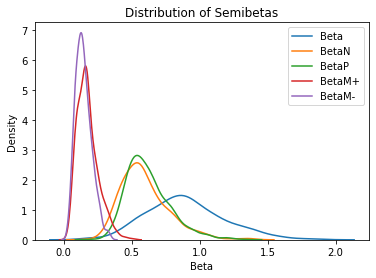

In [720]:
corrDF2=pd.DataFrame(columns=['Beta','BetaN','BetaP','BetaM+','BetaM-']) #Average across stock Function
count=0
for i in average:
    corrDF2[corrDF2.columns[count]]=i.mean(axis=0).tolist()
    count+=1

seaborn.kdeplot(corrDF2['Beta'])
seaborn.kdeplot(corrDF2['BetaN'])
seaborn.kdeplot(corrDF2['BetaP'])
seaborn.kdeplot(corrDF2['BetaM+'])
seaborn.kdeplot(corrDF2['BetaM-'])
plt.xlabel("Beta")
plt.ylabel("Density")
plt.title("Distribution of Semibetas")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Autocorrelation Function of Semibetas')

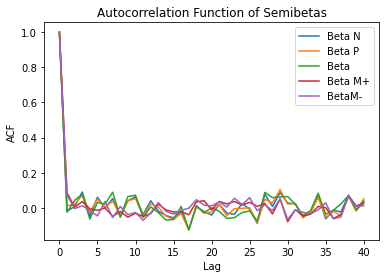

In [721]:
beta_acf=acf(corrDF2['Beta'],nlags=40)
betaN_acf=acf(corrDF2['BetaN'],nlags=40)
betaP_acf=acf(corrDF2['BetaP'],nlags=40)
betampos_acf=acf(corrDF2['BetaM+'],nlags=40)
betamneg_acf=acf(corrDF2['BetaM-'],nlags=40)
plt.plot(betaN_acf,label='Beta N')
plt.plot(betaP_acf,label='Beta P')
plt.plot(beta_acf,label='Beta')
plt.plot(betampos_acf,label='Beta M+')
plt.plot(betamneg_acf,label='BetaM-')
plt.legend(loc="upper right")
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function of Semibetas')

#### Preprocessing for Cross Sectional regression

In [727]:
#Transpore the matrix. Drop the first column for daily ret
crossd1=d1.T
crossd1.drop(crossd1.columns[0],axis=1,inplace=True) #For US MARKET
#Shift the beta matrix by 1 and remove the column with the nan value
crossbP =bP.shift(1).T
crossbN =bN.shift(1).T
crossmneg =bmneg.shift(1).T
crossmpos =bmpos.shift(1).T
crossnormal =bnormal.shift(1).T
crossbP.dropna(axis=1,inplace=True)
crossbN.dropna(axis=1,inplace=True)
crossmneg.dropna(axis=1,inplace=True)
crossmpos.dropna(axis=1,inplace=True)

In [580]:
crossd1

,26/5/2020 0:00,27/5/2020 0:00,28/5/2020 0:00,29/5/2020 0:00,1/6/2020 0:00,2/6/2020 0:00,3/6/2020 0:00,4/6/2020 0:00,5/6/2020 0:00,9/6/2020 0:00,...,22/9/2020 0:00,23/9/2020 0:00,24/9/2020 0:00,25/9/2020 0:00,28/9/2020 0:00,29/9/2020 0:00,30/9/2020 0:00,1/10/2020 0:00,2/10/2020 0:00,5/10/2020 0:00
A2M AT,-0.002235,-0.024076,0.006885,0.009117,-0.022586,-0.000578,0.011561,0.021143,-0.013990,0.000568,...,-0.001826,0.037805,-0.016451,0.025090,-0.114219,-0.040132,-0.037012,-0.002135,-0.002853,0.017883
ABC AT,0.031621,0.061303,0.021661,-0.038869,0.088235,0.030405,0.075410,0.024390,0.032738,-0.034582,...,-0.017921,0.014599,-0.025180,0.044280,0.014134,0.006969,-0.013841,0.024561,-0.020548,0.041958
ABP AT,0.043825,0.026718,-0.007435,-0.033708,-0.003876,-0.003891,0.007812,0.031008,0.033835,0.021818,...,0.029963,0.007273,0.036101,0.034843,-0.010101,0.003401,-0.013559,0.003436,-0.006849,0.024138
AGL AT,0.016324,0.011303,0.001176,-0.015276,0.003580,0.017241,0.016949,0.010920,-0.005685,0.032018,...,-0.021939,0.022431,0.007077,0.008433,0.001238,-0.017422,-0.034043,0.003671,-0.012436,0.025926
AIA AT,0.058407,0.023411,-0.016340,0.003322,-0.003311,0.013289,0.049180,0.023438,-0.018321,0.015552,...,-0.009245,0.031104,-0.022624,0.006173,0.024540,0.008982,-0.004451,0.008942,0.008837,0.001477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WPR AT,0.056452,0.000000,0.007634,0.003788,-0.011321,0.019084,-0.003745,-0.015038,-0.011450,0.034749,...,-0.014760,0.014981,0.007380,0.007326,0.003636,0.007246,-0.025180,0.014760,-0.003636,0.021898
WSA AT,0.004444,0.039823,-0.004255,-0.025641,0.017544,0.030172,0.025105,-0.028571,0.004202,0.008368,...,-0.039823,0.027650,-0.017937,0.004566,-0.031818,0.000000,-0.037559,0.019512,-0.023923,0.034314
WTC AT,0.014632,0.007210,-0.057718,-0.031814,-0.010790,0.046604,0.040265,0.025046,-0.015993,0.015801,...,0.018638,-0.000373,-0.022040,-0.014515,0.001163,0.034069,-0.034444,0.003102,-0.001546,0.005033
XRO AT,0.030788,-0.003998,0.003542,0.003176,0.015715,0.001501,0.029859,0.000560,-0.021929,-0.064173,...,0.043927,0.037450,-0.013689,0.003701,0.008297,0.029764,-0.006116,0.016476,0.007714,0.013857


In [416]:
#crossd1=crossd1.iloc[:,1:]

In [673]:
dailyfactors=pd.concat([crossbN.iloc[:,2],crossbP.iloc[:,2],crossmneg.iloc[:,2],crossmpos.iloc[:,2]],axis=1)
dailyfactors.columns=['betaN','betaP','betaM-','betaM+']
model = sm.OLS(crossd1.iloc[:,2],sm.add_constant(dailyfactors))
model.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         28/5/2020 0:00   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.718
Date:                Wed, 28 Oct 2020   Prob (F-statistic):              0.148
Time:                        09:33:26   Log-Likelihood:                 421.03
No. Observations:                 192   AIC:                            -832.1
Df Residuals:                     187   BIC:                            -815.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.006      0.190      0.850      -0.010       0.012
betaN          0.0213      0.009      2.240      0.026       0.003       0.040
betaP         -0.0073      0.005     -1.349      0.179      -0.018       0.003
betaM-         0.0079      0.020      0.390      0.697      -0.032       0.048
betaM+         0.0097      0.013      0.755      0.451      -0.016       0.035
==============================================================================
Omnibus:                       64.887   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.118
Skew:                           1.155   Prob(JB):                     2.55e-76
Kurtosis:                       9.179   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Cross Sectional Regression

In [731]:
def crs(ret,bN,bP,bmneg,bmpos): #For 92 fixed points run a Fama and Macbeth type cross-secitional predictive regression
    alphas=[]
    errors=[]
    betaP=[]
    betaN=[]
    betamneg=[]
    betampos=[]
    tvalalpha=[]
    tvalP=[]
    tvalN=[]
    tvalmneg=[]
    tvalmpos=[]
    errors=[]
    rsquared=[]
    P=0
    for a in ret.columns:
        dailyfactors=pd.DataFrame()
        dailyfactors=pd.concat([bN.iloc[:,P],bP.iloc[:,P],bmneg.iloc[:,P],bmpos.iloc[:,P]],axis=1)
        dailyfactors.columns=['betaN','betaP','betaM-','betaM+']
        model = sm.OLS(ret.iloc[:,P], sm.add_constant(dailyfactors[:]))
        fit=model.fit()
        alphas.append(fit.params["const"])
        betaN.append(fit.params[1])
        betaP.append(fit.params[2])
        betamneg.append(fit.params[3])
        betampos.append(fit.params[4])
        tvalalpha.append(fit.tvalues["const"])
        tvalN.append(fit.tvalues[1])
        tvalP.append(fit.tvalues[2])
        tvalmneg.append(fit.tvalues[3])
        tvalmpos.append(fit.tvalues[4])
        errors.append(fit.resid)
        rsquared.append(fit.rsquared_adj)
        P+=1
    return(alphas,betaN,betaP,betamneg,betampos,errors,rsquared,tvalalpha,tvalN,tvalP,tvalmneg,tvalmpos)

In [732]:
riskprem=crs(crossd1,crossbN,crossbP,crossmneg,crossmpos)
#riskprem[1]

In [734]:
sum(riskprem[1])

-0.006191640741773544

In [735]:
p=riskprem[1]
t=pd.Series(v for v in p)
t.describe().T

count    92.000000
mean     -0.000067
std       0.010505
min      -0.029395
25%      -0.006708
50%      -0.000326
75%       0.005891
max       0.039665
dtype: float64

In [741]:
def fm_summary(p):#Summary Statistics Function
    t=pd.Series((v for v in p ))
    s = t.describe().T
    s['std_error'] = s['std']/np.sqrt(s['count'])
    s['tstat'] = s['mean']/s['std_error']
    return s[['mean','std','tstat']].T


In [746]:
CSsummary=pd.concat([fm_summary(riskprem[1]),fm_summary(riskprem[2]),fm_summary(riskprem[3]),fm_summary(riskprem[4])],axis=1)
CSsummary.columns=['BetaN','BetaP','BetaM-','BetaM+']
CSsummary

,BetaN,BetaP,BetaM-,BetaM+
mean,-0.000067,-0.000239,-0.002531,0.001050
std,0.010505,0.012277,0.016439,0.019440
tstat,-0.061452,-0.187115,-1.476707,0.517881


In [425]:
riskpremcs=[] #Average of the risk premium across day
for i in range(0,12):
    #cleanedList = [x for x in riskprem[i] if not np.isnan(x)] # AusFor no return
    riskpremcs.append(sum(riskprem[i])/len(riskprem[i])) #for us market because no nan return
    # riskpremcs.append(sum(cleanedList)/len(cleanedList))#AusFor no return

In [426]:
listprem=[] 
tstat=[]
for i in range(1,5):  #skip the error term riskprem[6] orginally for AU market
    listprem.append(riskpremcs[i])
for j in range(7,11):
    tstat.append(riskpremcs[j])
rsquared=riskpremcs[6]
listprem

[-6.730044284536461e-05,
 -0.00023949711768427788,
 -0.0025309076322165423,
 0.0010496399307038332]

In [505]:
rsquared

0.0561534233364321

In [428]:
CSsummary.index=['Mean','T-stat']
CSsummary

,BetaN,BetaP,BetaM-,BetaM+
Mean,-0.000067,-0.000239,-0.002531,0.001050
T-stat,0.839398,-0.000520,-0.198431,-0.329009


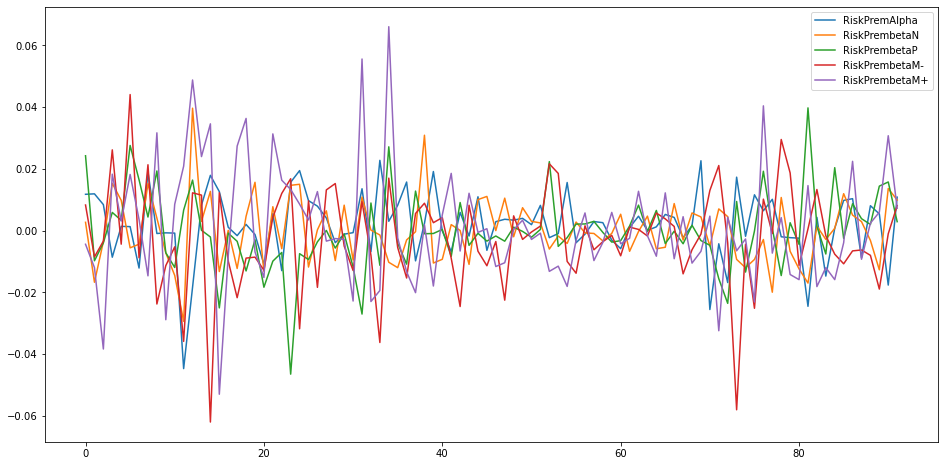

In [747]:
RISKPREM=pd.DataFrame(columns=['RiskPremAlpha','RiskPrembetaN','RiskPrembetaP','RiskPrembetaM-','RiskPrembetaM+'])
RISKPREM[RISKPREM.columns[0]]=riskprem[0]
RISKPREM[RISKPREM.columns[1]]=riskprem[1]
RISKPREM[RISKPREM.columns[2]]=riskprem[2]
RISKPREM[RISKPREM.columns[3]]=riskprem[3]
RISKPREM[RISKPREM.columns[4]]=riskprem[4]
RISKPREM.plot(figsize=(16,8))

### Compute the mean model r2 score


In [748]:
dfObj=pd.DataFrame(riskprem[1])
dfObj.shift(1).dropna()

,0
1,0.002688
2,-0.016738
3,-0.003585
4,0.015313
5,0.009823
...,...
87,0.005024
88,0.002927
89,-0.003187
90,-0.012699


In [749]:
 #For 92 fixed points run a Fama and Macbeth type cross-secitional predictive regression with the average riskpremium as an indicator of turure return
count=0
r2=[]
for i in crossd1.columns:
    y_pred=riskpremcs[0]+listprem[0]*crossbN.iloc[:,count]+listprem[1]*crossbP.iloc[:,count]+listprem[2]*crossmneg.iloc[:,count]+listprem[3]*crossmpos.iloc[:,count]
    y_true=crossd1[crossd1.columns[count]]
    score=r2_score(y_true,y_pred)
    r2.append(score)
    count+=1
    


In [750]:
dr2=pd.DataFrame(columns=['R2'])
dr2['R2']=r2


In [1396]:
 #For 92 fixed points run a Fama and Macbeth type cross-secitional predictive regression to test previous day risk prem as  an indicator of future returns
count=0
r2new=[]
for i in crossd1.columns:
    if count+1==92:
        None
    else:
        y_pred=riskprem[0][count]+riskprem[1][count]*crossbN.iloc[:,count+1]+riskprem[2][count]*crossbP.iloc[:,1]+riskprem[3][count]*crossmneg.iloc[:,count+1]+riskprem[4][count]*crossmpos.iloc[:,count+1]
        y_true=crossd1[crossd1.columns[count+1]]
        score=r2_score(y_true,y_pred)
        r2new.append(score)
    count+=1
    
    


In [751]:
sum(r2)/len(r2)

-0.4490902875538643

### Interday data closing price of s&p500 constituents

In [1416]:
dailydf23=pd.DataFrame()
for sym in sp500equity:
    ds=blp.bdh(tickers=sym,flds=['last_price'],start_date='1999-01-01',end_date='2020-10-1')
    if not ds.empty:
        ds.columns=ds.columns.droplevel()
        dailydf23=pd.concat([dailydf23,ds],axis=1)
    else:
        print(sym)


In [1490]:
dailydf23.columns=data
dailydf23.loc['2015-01-01':].columns[dailydf23.loc['2015-01-01':].isnull().sum()>10].tolist()

['AEP UW',
 'AMCR UN',
 'APA UW',
 'CARR UN',
 'CSX UW',
 'CTVA UN',
 'DOW UN',
 'DXC UN',
 'ETSY UW',
 'EXC UW',
 'FOX UW',
 'FOXA UW',
 'FTV UN',
 'HPE UN',
 'HWM UN',
 'INFO UN',
 'IR UN',
 'KHC UW',
 'LNT UW',
 'LW UN',
 'NBL UW',
 'NCLH UN',
 'NWL UW',
 'OTIS UN',
 'PEP UW',
 'PFG UW',
 'PYPL UW',
 'REG UW',
 'TER UW',
 'TMUS UW',
 'UA UN',
 'UAL UW',
 'VIAC UW',
 'WLTW UW',
 'WRK UN',
 'XEL UW']

## Cross-sectional Factor Portfolio

In [815]:
import statistics
import pyfolio as pf
import pandas_datareader as web
w1=61452/(61452+1476707) #Factor weightage based on T-stat for Semi Betas
w2=1-w1

Text(0.5, 1.0, 'S&P500 Index Closing Price')

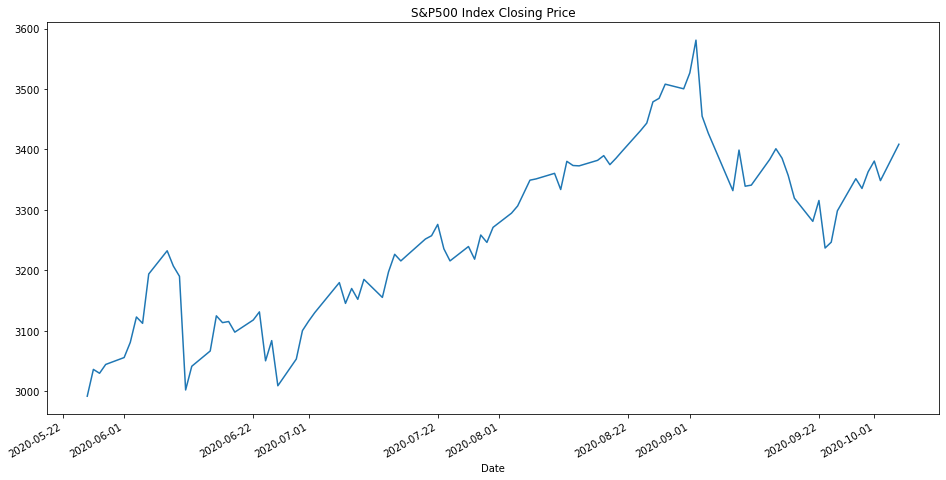

In [863]:
SPY=web.DataReader('^GSPC','yahoo',start='5-25-2020',end='10-5-2020')
SPY['Adj Close'].plot(figsize=(16,8))
plt.title('S&P500 Index Closing Price')

## Decision RANKING

In [906]:
def rankfactorreturn(crossd1,crossbN,crossmneg):
    dailypnl=[]
    i=0
    crossd1=np.log(1+crossd1)
    for ab in crossd1.columns:
        r=pd.concat([crossd1.iloc[:,i],(crossbN.iloc[:,i])],axis=1)
        r.columns=['Returns','Factors']
        r=r.sort_values(by='Factors',ascending=False)
        thres=[.75,.25]
        upper=r.quantile([thres[0],thres[1]],axis=0)['Factors'][thres[0]] #Top 25 Quintile 
        lower=r.quantile([thres[0],thres[1]],axis=0)['Factors'][thres[1]] #Lower 25 Quintile
        retlong=r[r['Factors']>upper]['Returns'].sum()*1
        retshort=r[r['Factors']<lower]['Returns'].sum()*-1
        dailypnl.append(retlong+retshort)
        i+=1
    return dailypnl

In [895]:
crossbeta=crossbN-crossmneg+crossbP-crossmpos
crossbeta.head()

,2020-05-27 00:00:00,2020-05-28 00:00:00,2020-05-29 00:00:00,2020-06-01 00:00:00,2020-06-02 00:00:00,2020-06-03 00:00:00,2020-06-04 00:00:00,2020-06-05 00:00:00,2020-06-08 00:00:00,2020-06-09 00:00:00,...,2020-09-22 00:00:00,2020-09-23 00:00:00,2020-09-24 00:00:00,2020-09-25 00:00:00,2020-09-28 00:00:00,2020-09-29 00:00:00,2020-09-30 00:00:00,2020-10-01 00:00:00,2020-10-02 00:00:00,2020-10-05 00:00:00
A UN,0.359233,1.075269,0.854235,0.621865,0.603868,1.079736,1.337684,0.942835,1.224649,0.484853,...,0.872827,0.554463,0.861789,0.633446,1.118527,1.686331,0.711235,0.867535,1.061104,0.963577
AAL UW,1.252661,3.608485,1.672956,2.310211,4.460692,1.463092,2.487948,7.211513,9.147209,1.625612,...,1.484187,0.899941,1.745462,1.390260,1.558116,-0.155514,1.355592,1.819357,1.884292,2.336606
AAP UN,1.275105,0.241871,1.031711,0.748445,0.879922,0.939828,1.088733,1.404866,1.438440,-0.119805,...,0.457261,1.398936,0.733319,0.908762,0.615932,1.648507,0.376690,0.947965,1.388897,1.138745
AAPL UW,1.547639,1.035289,1.225238,0.625215,0.991252,0.953876,0.886510,0.840162,0.479551,1.067233,...,2.039303,1.615244,1.703272,1.511983,1.171084,1.112426,1.127328,1.459406,1.007056,1.386717
ABBV UN,0.536083,1.033499,0.592273,0.987609,1.127408,1.123728,0.920368,0.727242,0.709065,0.452079,...,0.919516,0.812665,0.454657,0.478690,0.648092,0.776136,0.931714,0.832816,0.782080,0.820797


In [911]:
portRetSummary=pd.DataFrame(columns=['TraditionalBeta','Semi Beta','Beta N','BetaM-','BetaP','BetaM+'],index=['Avg Ret','Std dev','Sharpe'])
c=0
for i in [crossbeta,(crossbP-crossmneg),crossbN,-crossmneg,crossbP,crossmpos]:
    pnl=rankfactorreturn(crossd1,i,0)
    avgpnl=(sum(pnl))/len(pnl)
    sharpe=(avgpnl)/np.std(pnl)*np.sqrt(252)
    portRetSummary[portRetSummary.columns[c]]=[avgpnl*np.sqrt(252),np.std(pnl),sharpe]#annualize the avg ret
    c+=1
portRetSummary


,TraditionalBeta,Semi Beta,Beta N,BetaM-,BetaP,BetaM+
Avg Ret,0.231242,1.029608,-0.939097,1.119712,0.377187,-0.936269
Std dev,1.247574,1.105576,1.254813,0.825875,1.153028,0.854571
Sharpe,0.185354,0.931287,-0.748396,1.355789,0.327128,-1.095601


In [945]:
stock_rets = web.DataReader('FB','yahoo',start='10-10-2010',end='10-10-2019').pct_change()
stock_rets.dropna(inplace=True)

In [950]:
stock_rets.index

DatetimeIndex(['2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-29', '2012-05-30', '2012-05-31',
               '2012-06-01', '2012-06-04',
               ...
               '2019-09-27', '2019-09-30', '2019-10-01', '2019-10-02',
               '2019-10-03', '2019-10-04', '2019-10-07', '2019-10-08',
               '2019-10-09', '2019-10-10'],
              dtype='datetime64[ns]', name='Date', length=1860, freq=None)

In [245]:
#os.chdir('C:\\Users\\raymond.widjaja\\Desktop')
#os.getcwd
#listdf=pd.DataFrame(sp500equity,columns=['List'])
#listdf.to_csv('list.csv')
#dailydf23.to_csv('DailyUSequityunformatted.csv')